In [3]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
def create_random_digraph(n, p):
    # G = nx.DiGraph()
    # for i in range(n):
    #     # G.add_edge(i, i, weight=1)
    #     for j in range(n):
    #         if i != j and np.random.rand() < p:
    #             w = np.random.uniform(0.0, 1.0)
    #             G.add_edge(i, j, weight=w)
    G = nx.fast_gnp_random_graph(n, p, directed=True)
    for u, v, d in G.edges(data=True):
        d['weight'] = np.random.uniform(0.0, 1.0)

    return G

def create_cycle(n):
    G = nx.DiGraph()
    for i in range(n):
        G.add_edge(i, (i+1)%n, weight=1.0)

    return G 

def to_absolute_capacities(G, max_money=1000):
    G_abs = nx.DiGraph()
    for u, v, d in G.edges(data=True):
        G_abs.add_edge(u, v, capacity=int(d['weight']*max_money))
    return G_abs

def to_relative_weights(G, p):
    G_rel = nx.DiGraph()
    for u, v, d in G.edges(data=True):
        deposit = p[u]
        G_rel.add_edge(u, v, weight=d['weight']/deposit)
    return G_rel


def create_random_digraph_absolute(n, p, max_money=1000):
    return to_absolute_capacities(create_random_digraph(n, p), max_money)

In [1]:
def to_flow_graph(G, p):
    G_flow = nx.DiGraph()
    G_flow.add_node('s')
    for u in G.nodes():
        G_flow.add_edge('s', u, capacity=p[u])
    for u, v, d in G.edges(data=True):
        G_flow.add_edge(u, v, **d)
    return G_flow

def maxflow_to(G, p, u):
    G_flow = to_flow_graph(G, p)
    return nx.maximum_flow_value(G_flow, 's', u)

def maxflow_full(G, p):
    G_flow = to_flow_graph(G, p)
    f = np.zeros(p.shape)
    for u in G.nodes():
        f[u] = nx.maximum_flow_value(G_flow, 's', u)
    return f

def eigentrust(C, r_init=None, alpha=0.7, epsilon=1e-6, return_trace=False):
    n = C.shape[0]
    if r_init is None:
        r_init = np.ones((n, 1)) / n
    # else:
    #     r_init = r_init / r_init.sum()
    
    r = r_init
    trace = [(r_init, 0.0)]
    while True:
        r_new = alpha * C @ r + (1 - alpha) * r_init
        norm = np.linalg.norm(r_new - r)
        if norm < epsilon:
            break
        r = r_new
        trace.append((r_new, norm))

    if return_trace:
        return r_new, trace
    return r_new


def eigentrust_full(G, p, **kwargs):
    C = nx.adjacency_matrix(G, weight='capacity')
    sums = C.sum(axis=0)
    sums[sums == 0] = 1
    C = C / sums

    r = eigentrust(C, p, **kwargs)
    return r

def partial_flow(G, p):
    f = p.copy()
    for u in G.nodes():
        for v, _, data in G.in_edges(u, data=True):
            f[u] += data['weight'] * p[v]
    return f

In [49]:
C = np.array([
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.5, 0.5],
    [0.0, 0.5, 0.0, 0.5],
    [0.0, 0.5, 0.5, 0.0],
])
r_init = np.array([0.0, 1.0, 0.0, 0.0])

r, trace = eigentrust(C.T, r_init, alpha=0.67, return_trace=True)

In [50]:
r

array([0.        , 0.49812745, 0.25093627, 0.25093627])

In [48]:
r_hmm = np.array(r)
r_hmm[0] = 1.0
C.T @ r_hmm


array([0.        , 0.25093627, 0.37453186, 0.37453186])

In [45]:
x = r_hmm
for i in range(10):
    x = C.T @ x
    print(x)

[1.         0.66333325 0.66333337 0.66333337]
[1.         0.99333337 0.99333331 0.99333331]
[1.         1.32333331 1.32333334 1.32333334]
[1.         1.65333334 1.65333333 1.65333333]
[1.         1.98333333 1.98333334 1.98333334]
[1.         2.31333334 2.31333333 2.31333333]
[1.         2.64333333 2.64333333 2.64333333]
[1.         2.97333333 2.97333333 2.97333333]
[1.         3.30333333 3.30333333 3.30333333]
[1.         3.63333333 3.63333333 3.63333333]


In [18]:
sp.linalg.eig(C.T, left=True)

(array([-0.5+0.j,  1. +0.j, -0.5+0.j,  0. +0.j]),
 array([[-0.36514837,  0.5       ,  0.81649658,  1.        ],
        [ 0.18257419,  0.5       , -0.40824829,  0.        ],
        [ 0.54772256,  0.5       ,  0.40824829,  0.        ],
        [-0.73029674,  0.5       ,  0.        ,  0.        ]]),
 array([[ 0.        ,  0.        ,  0.        ,  0.5       ],
        [ 0.40824829,  0.57735027, -0.79259392,  0.5       ],
        [ 0.40824829,  0.57735027,  0.56613852, -0.5       ],
        [-0.81649658,  0.57735027,  0.22645541, -0.5       ]]))

In [5]:
G = create_random_digraph(100, 0.03)


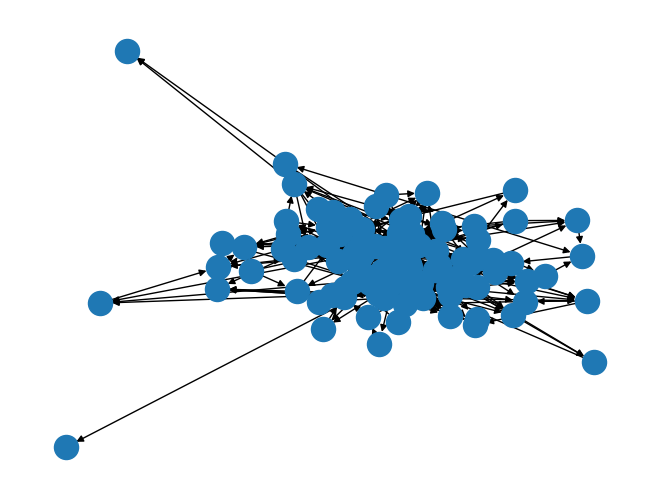

In [7]:
nx.draw(G)
plt.show()


In [5]:
G_abs = create_random_digraph_absolute(100, 0.03)

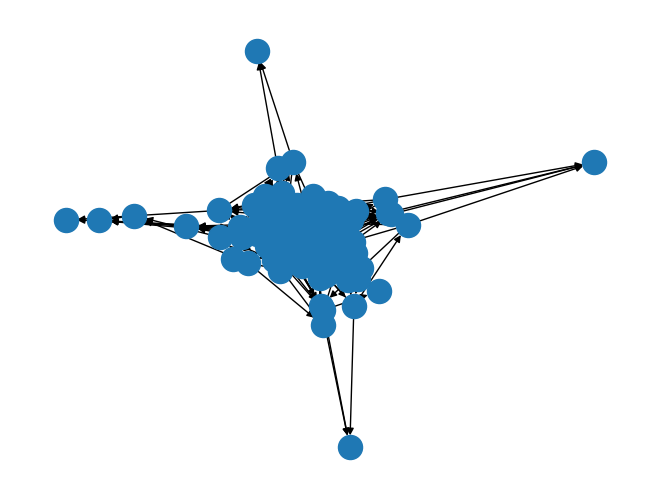

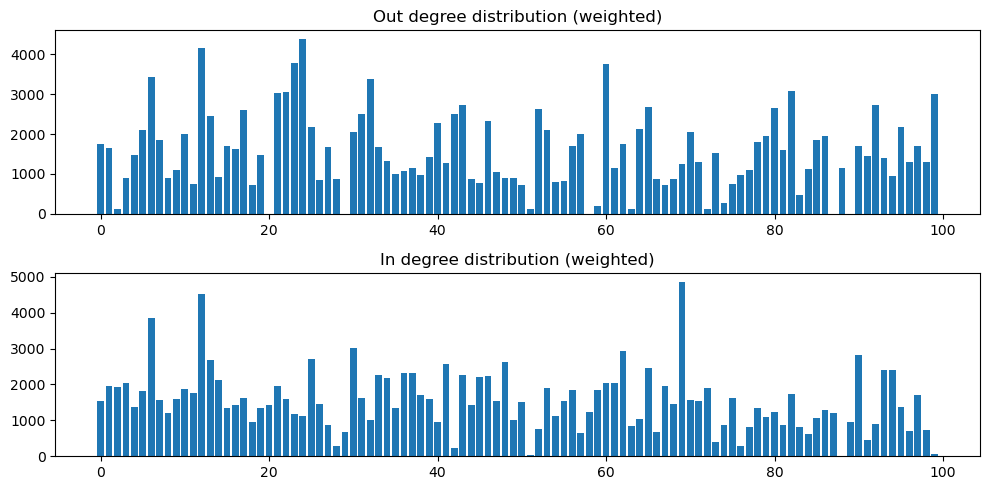

In [6]:
nx.draw(G_abs)
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
plt.sca(ax[0])
plt.title("Out degree distribution (weighted)")
plt.bar(range(len(G_abs.nodes)), [d[1] for d in G_abs.out_degree(weight='capacity')])
plt.sca(ax[1])
plt.title('In degree distribution (weighted)')
plt.bar(range(len(G_abs.nodes)), [d[1] for d in G_abs.in_degree(weight='capacity')])
fig.tight_layout()
plt.show()

In [8]:
import time

def plot_initial_and_final(G, p, alg=maxflow_full):
    start_time = time.time()
    f = alg(G, p)
    dur = time.time() - start_time
    print(f"Running time: {dur:0.2f} s")
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    plt.sca(ax[0])
    plt.title(f"Initial deposits (sum={p.sum():0.2f})")
    plt.bar(np.arange(len(p)), p)
    plt.xlabel('Node')
    plt.ylabel('$')
    plt.sca(ax[1])
    plt.title(f"Final trust evaluations (sum={f.sum():0.2f})")
    plt.bar(np.arange(len(f)), f)
    plt.xlabel('Node')
    plt.ylabel('$')
    fig.tight_layout()
    plt.show()

def compare_eigentrust_and_maxflow(G, p):
    print('EigenTrust')
    plot_initial_and_final(G, p, alg=eigentrust_full)

    print('MaxFlow')
    plot_initial_and_final(G, p, alg=maxflow_full)

Running time: 0.00 s


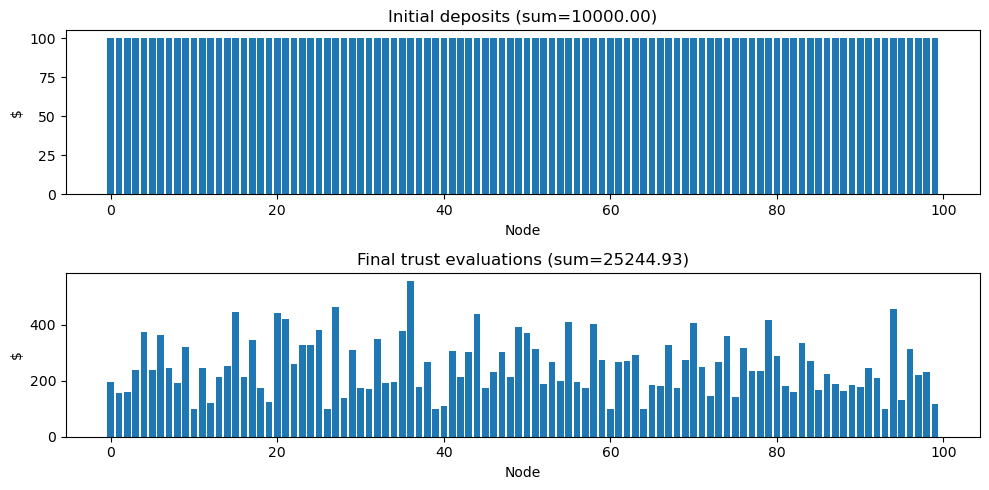

In [17]:
p = np.ones(100) * 100

plot_initial_and_final(G, p, alg=partial_flow)

Running time: 0.00 s


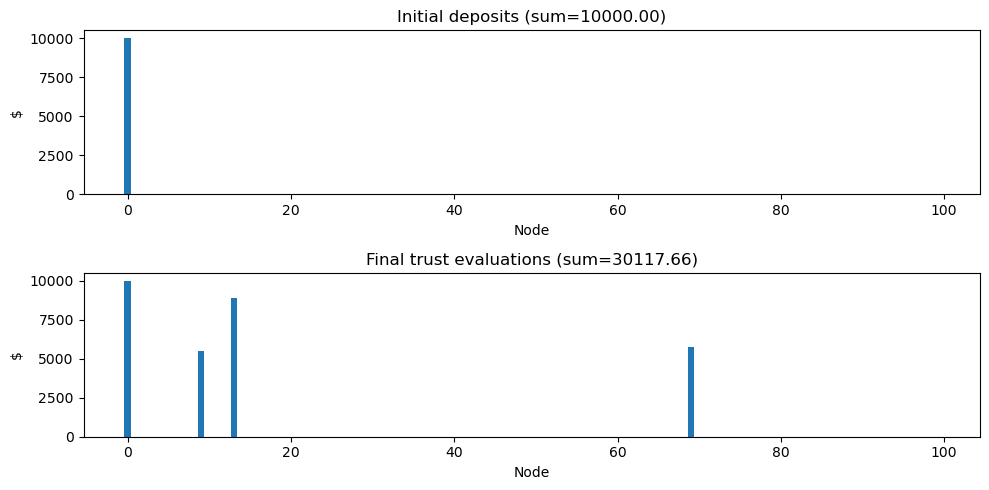

In [18]:
p = np.zeros(100)
p[0] = 10000
plot_initial_and_final(G, p, alg=partial_flow)

Running time: 0.41 s


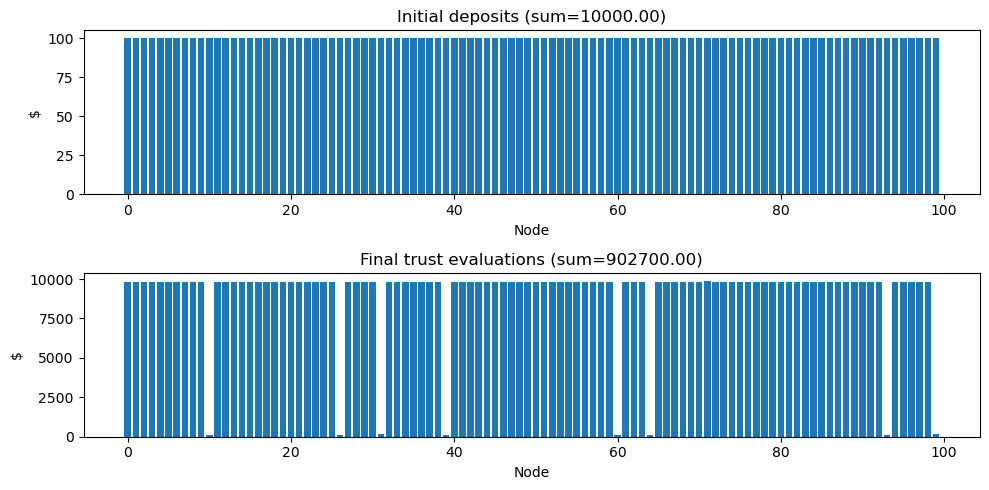

In [12]:
plot_initial_and_final(G, p, alg=maxflow_full)

In [25]:
p = np.ones(G_abs.number_of_nodes()) * 100
compare_eigentrust_and_maxflow(G_abs, p)

NameError: name 'G_abs' is not defined

EigenTrust
Running time: 0.02 s


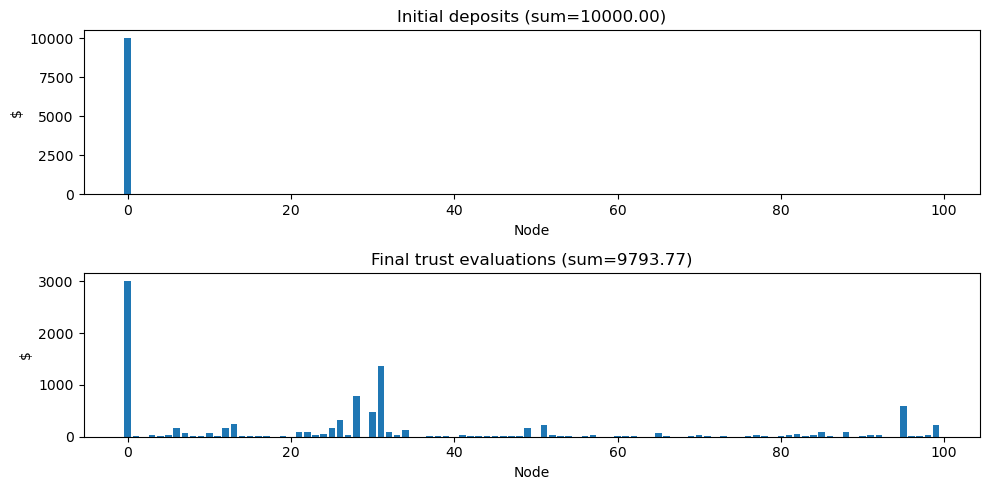

MaxFlow
Running time: 0.39 s


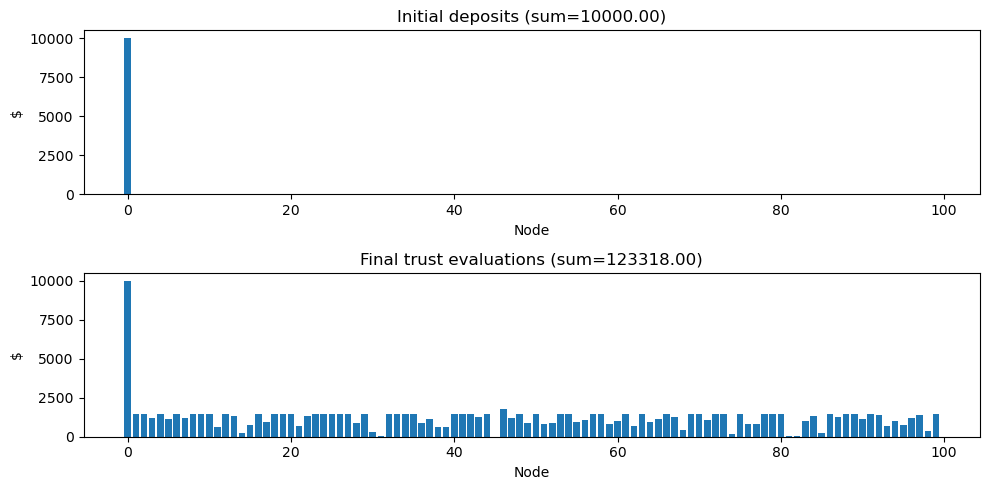

In [9]:
p = np.zeros(G_abs.number_of_nodes())
p[0] = 10000

compare_eigentrust_and_maxflow(G_abs, p)

EigenTrust
Running time: 0.02 s


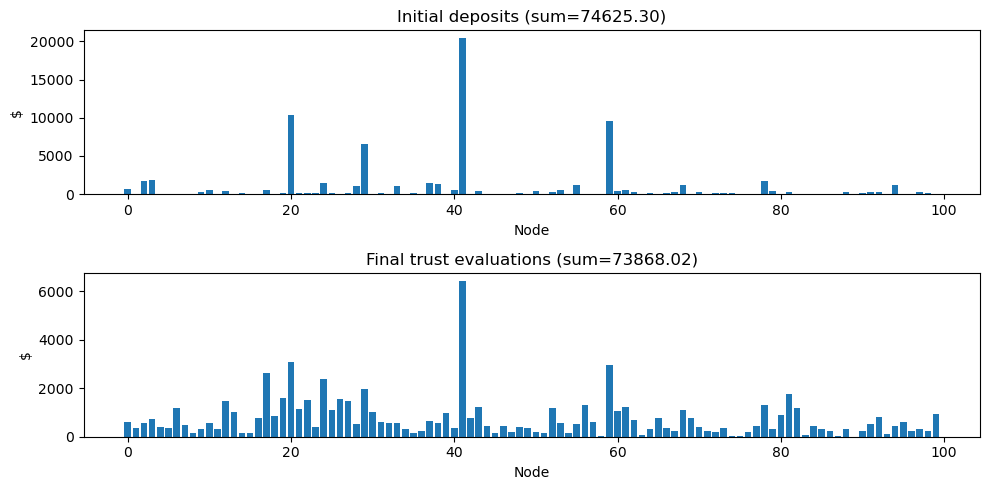

MaxFlow
Running time: 0.86 s


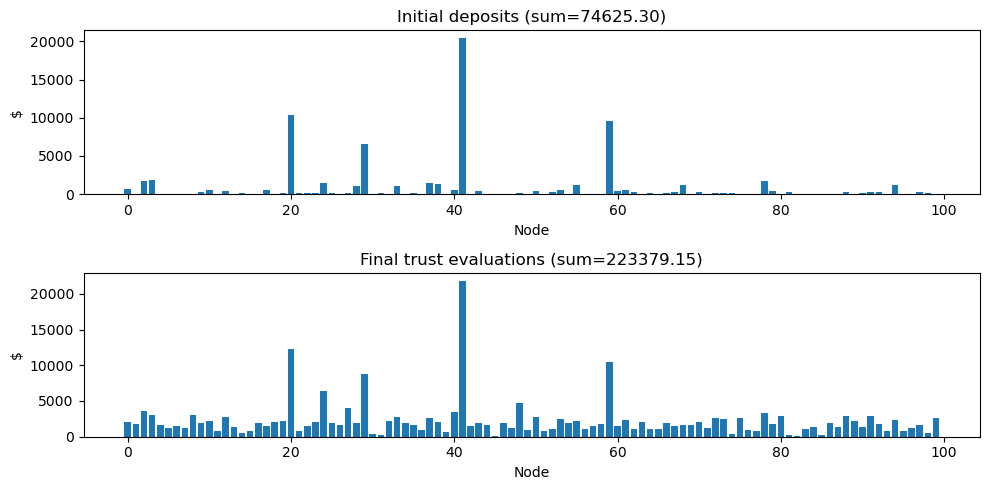

In [10]:
p = np.random.pareto(1.0, G_abs.number_of_nodes())*100
compare_eigentrust_and_maxflow(G_abs, p)

In [210]:
G = create_random_digraph(30, 0.15)
nx.is_strongly_connected(G)

True

True

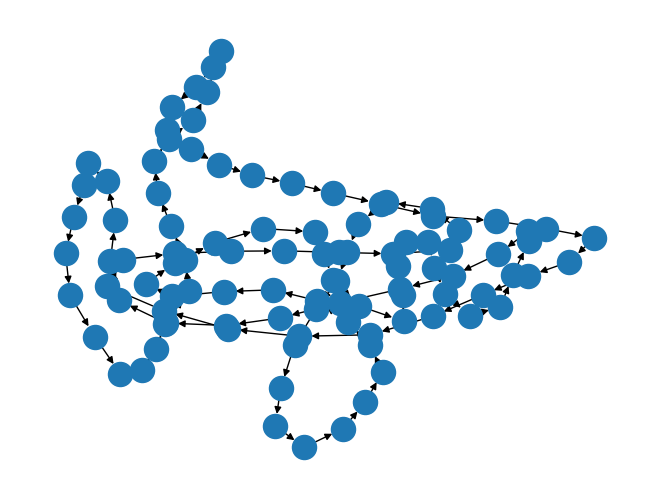

In [82]:
Gc = create_cycle(100)
nx.draw(Gc)
nx.is_strongly_connected(Gc)

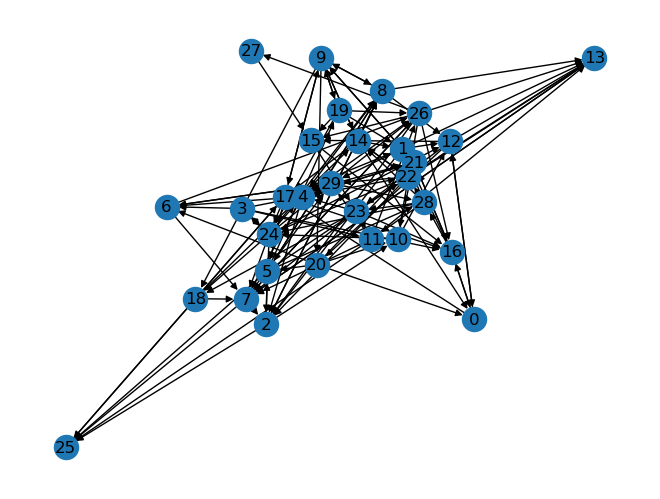

In [259]:
nx.draw(G, with_labels=True)

[1.23179425 1.81615791 2.63009028 1.27781795 3.14284194 2.65371231
 4.66776296 4.10382115 3.46816681 2.20146337 1.81726876 2.56366778
 1.69030194 2.49676897 0.91779306 3.77805987 2.58576882 1.57921156
 3.08364245 3.04158475 1.53981902 2.7533257  1.59105644 2.46618453
 1.28826049 1.6042384  0.30993851 2.56395285 1.42456707 0.81209332]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


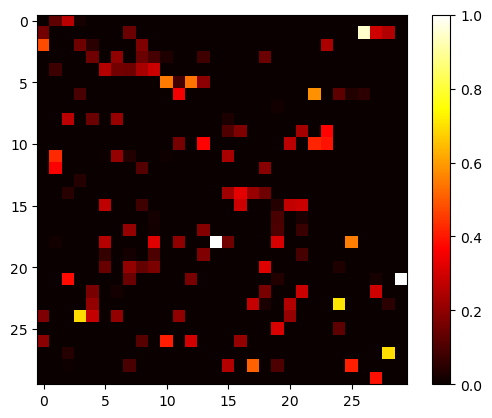

In [212]:
C = nx.adjacency_matrix(G)
sums = C.sum(axis=0)
print(sums)
C = (C / sums).todense()
print(C.sum(axis=0))
plt.imshow(C, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [197]:
clique_graph = (np.ones((30, 30)) - np.eye(30))
clique_graph = clique_graph / clique_graph.sum(axis=0)
clique_graph

array([[0.        , 0.03448276, 0.03448276, 0.03448276, 0.03448276,
        0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276,
        0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276,
        0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276,
        0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276,
        0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276],
       [0.03448276, 0.        , 0.03448276, 0.03448276, 0.03448276,
        0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276,
        0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276,
        0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276,
        0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276,
        0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276],
       [0.03448276, 0.03448276, 0.        , 0.03448276, 0.03448276,
        0.03448276, 0.03448276, 0.03448276, 0.03448276, 0.03448276,
        0.03448276, 0.03448276, 0.03448276, 0.

In [181]:
t = sp.linalg.solve(np.eye(30) - clique_graph.T*0.99, np.ones(30)/30)

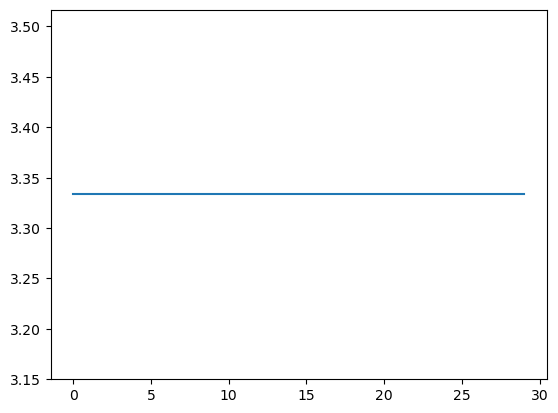

In [182]:
plt.plot(np.arange(len(t)), t)

In [94]:
np.all(C <= 1)

True

In [98]:
B = np.zeros(C.shape)
Z = C

for i in range(C.shape[0]):
    B += Z
    Z = C @ Z

In [99]:
np.all(C > 0)

False

In [100]:
np.all(B > 0)

True

In [104]:
B = np.eye(C.shape[0])

for i in range(C.shape[0]+1):
    B = C @ B

    if np.all(B > 0):
        print(i+1, "no zeros!")
        
    if np.allclose(B, np.eye(C.shape[0])):
        print(i+1, "converged!")

    isclose = np.allclose(B, C)
    if isclose:
        print(i+1, np.allclose(B, C))

1 True
100 converged!
101 True


In [54]:
B.sum(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [16]:
np.linalg.eig(C.T.todense())

EigResult(eigenvalues=array([ 9.94890768e-01+0.00000000e+00j,  6.91777916e-01+1.99446950e-01j,
        6.91777916e-01-1.99446950e-01j,  6.97043884e-01+0.00000000e+00j,
        6.45074020e-01+2.58628688e-01j,  6.45074020e-01-2.58628688e-01j,
        6.05053672e-01+3.43657693e-01j,  6.05053672e-01-3.43657693e-01j,
        6.75076405e-01+1.11320142e-01j,  6.75076405e-01-1.11320142e-01j,
        6.43353711e-01+0.00000000e+00j,  4.50301418e-01+5.41046528e-01j,
        4.50301418e-01-5.41046528e-01j,  5.53432068e-01+3.62184384e-01j,
        5.53432068e-01-3.62184384e-01j,  1.44692703e-01+7.05427556e-01j,
        1.44692703e-01-7.05427556e-01j,  4.96510401e-01+4.22684329e-01j,
        4.96510401e-01-4.22684329e-01j, -4.36363011e-02+7.29387232e-01j,
       -4.36363011e-02-7.29387232e-01j,  6.05354784e-01+1.27992912e-01j,
        6.05354784e-01-1.27992912e-01j,  4.61175430e-01+4.66171207e-01j,
        4.61175430e-01-4.66171207e-01j,  2.94758254e-01+6.13505974e-01j,
        2.94758254e-01-6.1350

<BarContainer object of 1000 artists>

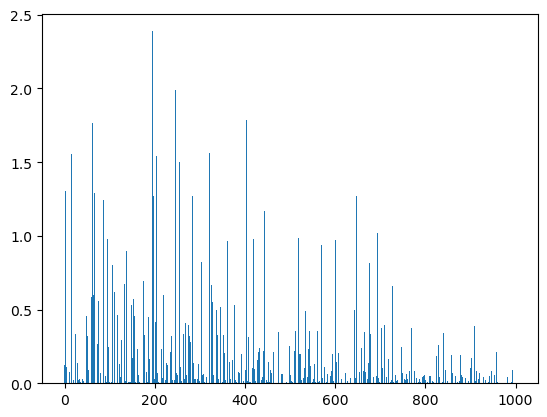

In [27]:
hmm = np.linalg.solve(np.eye(1000) - C.T, np.ones(1000)/1000)
plt.bar(np.arange(C.shape[0]), hmm)

In [18]:
np.min(hmm)

1.003362495418705

1000.0


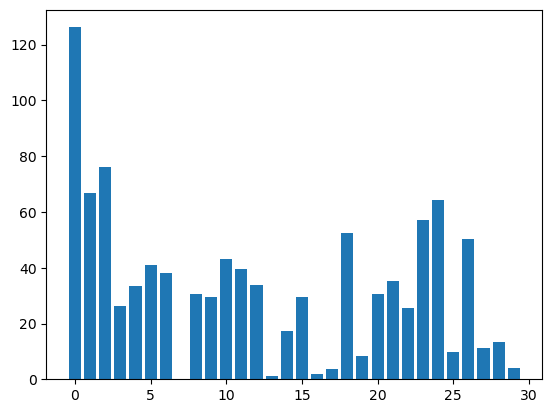

In [278]:
p = np.zeros((C.shape[0], 1))
p[0, 0] = 1000.0

t, trace = eigentrust(C, alpha=0.9, r_init=p, return_trace=True)
plt.bar(np.arange(len(t)), t.squeeze())
print(t.sum())

In [274]:
len(trace)

34

Text(0, 0.5, 'Norm of difference between r and r_new')

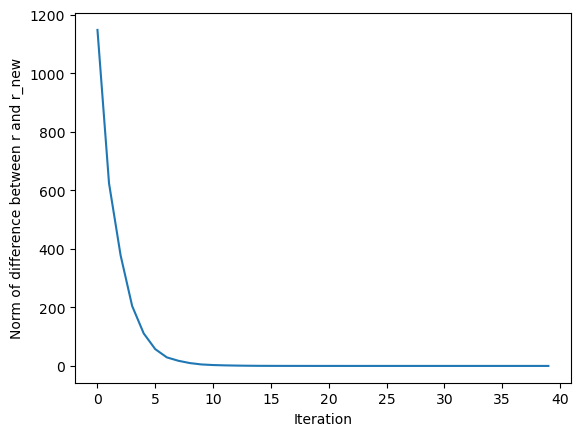

In [262]:
plt.plot(np.arange(len(trace)-1), [t[1] for t in trace[1:]])
plt.xlabel('Iteration')
plt.ylabel('Norm of difference between r and r_new')